
# Labeling images with 2 labels using machine learning

## Data source

 * Data source are files `train.csv` and `evaluate.csv`.
 * It's 28x28 pixels with black and white values from [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * File `train.csv` contains training data.
 * Predicted value is **label**.
 * File `evaluate.csv` contains testing data without label.

## Goal

Try out multiple machine learning models to train and reduce dimensions. Optimize hyperparameters and pick the best model to predict labels in  `evaluate.csv`.

Create a new file `results.csv` with an output of the following format:
```
ID,label
0,0
1,1
...
```


In [105]:
# IMPORTS

import pandas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from collections import defaultdict
from typing import Type
from sklearn.svm import SVC
from scipy import optimize
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler


random_seed = 11

%matplotlib inline


<h1>Analysis of the data</h1>

In this section, we're going to do an initial analysis of the data to better understand them.
- count the distribution of pixel values
- draw the pictures to make a better sense of them

<h2>Data shape and distribution</h2>
We're going to count the distribution of different pixel values and investigate the shape of the data.

In [106]:
### odtud už je to Vaše
df = pd.read_csv('train.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 9.0 MB


We have 1500 images for training from fashion dataset. Each image has 784 pixels, with values between 0 and 255. The pixels are grey-scale, with higher number meaning darker color. 

In [107]:
df["label"].value_counts()

label
0    759
1    741
Name: count, dtype: int64

Our predicted column Y called label has values 0 and 1 with about the same count. It's some groups of clothing, we'll find out which later.

Next we'll calculate which pixel values are the most common across all data.

In [108]:
value_frequencies = df.drop(columns=['label']).stack().value_counts()
print(value_frequencies)
print("median:", value_frequencies.median())

0      568082
255      9864
1        8988
2        6221
220      5094
        ...  
12        888
13        883
15        863
10        850
16        849
Name: count, Length: 256, dtype: int64
median: 1805.5


- Almost all values are zeros, we have a lot of excessive data, might be a good candidate for compression
- We can say that our data is *sparse* - many 0s
- Other value counts are in a range [849, 9864]
- The most frequent values except 0 are 255 and 1, the extremes.
- Median frequency count is 1805.5, an average pixel's value is 1805 times across all the data
- Pixel values are quite evenly distributed (except 0), no pixel value is missing

<h2> Analysis of zeros vs non-zeros per pixel/column </h2>

We know that most of the pixel values will be zeros, what about non-zero values against zeros? Are some pixels more important?

In [109]:
non_zero_counts = df.drop(columns=['label']).apply(lambda col: (col != 0).sum()).sort_values()

print(non_zero_counts)
print("avg:", round(non_zero_counts.mean(), 2))
print("median:", round(non_zero_counts.median(), 2))

pixel1         0
pixel2         0
pixel28        0
pixel57        1
pixel84        1
            ... 
pixel436    1498
pixel435    1498
pixel432    1498
pixel460    1499
pixel348    1499
Length: 784, dtype: int64
avg: 775.41
median: 847.5


Our conclusions based on the data are:

- There are 3 pixels that have all 0s
- There are also pixels that have almost no zero values (pixel 348 has only 1 zero).
    - Therefore, some pixels will be more important than others (some may be irrelevant)
</br></br>

- Since our dataset is 1500 pictures, about half of the values are non-zero per column
    - That means that about half of the pixels will be 0s and half will be non-zeros per column

<h2> Drawing the pictures </h2>
We're going to draw the pictures to more understand what they mean.

First, we'll draw a picture with the most 0 value pixels, and then with the least. 

In [110]:
most_zeros = df.drop(columns=['label']).apply(lambda row: (row == 0).sum(), axis=1)
print(most_zeros.sort_values())
print("mean:", most_zeros.mean())
print("median:", most_zeros.median())

852      81
855     166
1385    176
1234    178
119     183
       ... 
205     609
136     610
710     611
693     612
1075    614
Length: 1500, dtype: int64
mean: 378.72133333333335
median: 368.0


On average, 1 picture has 379 0s, which is around 48%. These pictures may be a good candidate for dimension reduction.

But why does 1 picture have only 81 0s, while another has 614?

We'll draw the picture with id 852 which has the least 0s (81), and the picture with id 1075 which has the most zeros.

In [111]:
def draw_picture(picture_index: int):
    
     picture = df.drop(columns=['label']).iloc[picture_index].values.reshape(28, 28)
     plt.imshow(picture, cmap='gray_r', interpolation='nearest', vmin=0, vmax=255)
     plt.axis('off')
     plt.show()

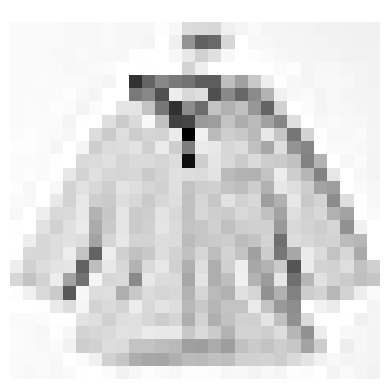

In [112]:
draw_picture(852)

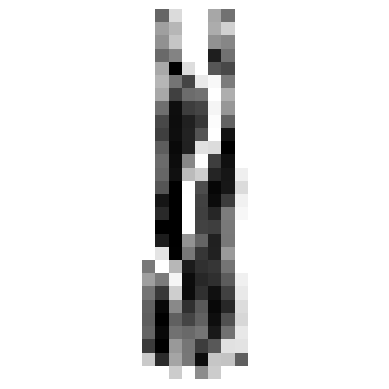

In [113]:
draw_picture(1075)

Very interesting, image with least zeros had a grey background while image with most had fully white background. Therefore background won't always be the same color.

<h3>Drawing labels</h3>
What do the label=0 and label=1 mean? We're going to draw 24 images from each label and try to observe which label means what.

In [114]:
def draw_grid(image_ids: list[int]):
    fig, axes = plt.subplots(6, 4, figsize=(10, 20))
    for ax, idx in zip(axes.flatten(), image_ids):
        picture = df.drop(columns=['label']).iloc[idx].values.reshape(28, 28)
        ax.imshow(picture, cmap='gray_r', interpolation='nearest', vmin=0, vmax=255)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

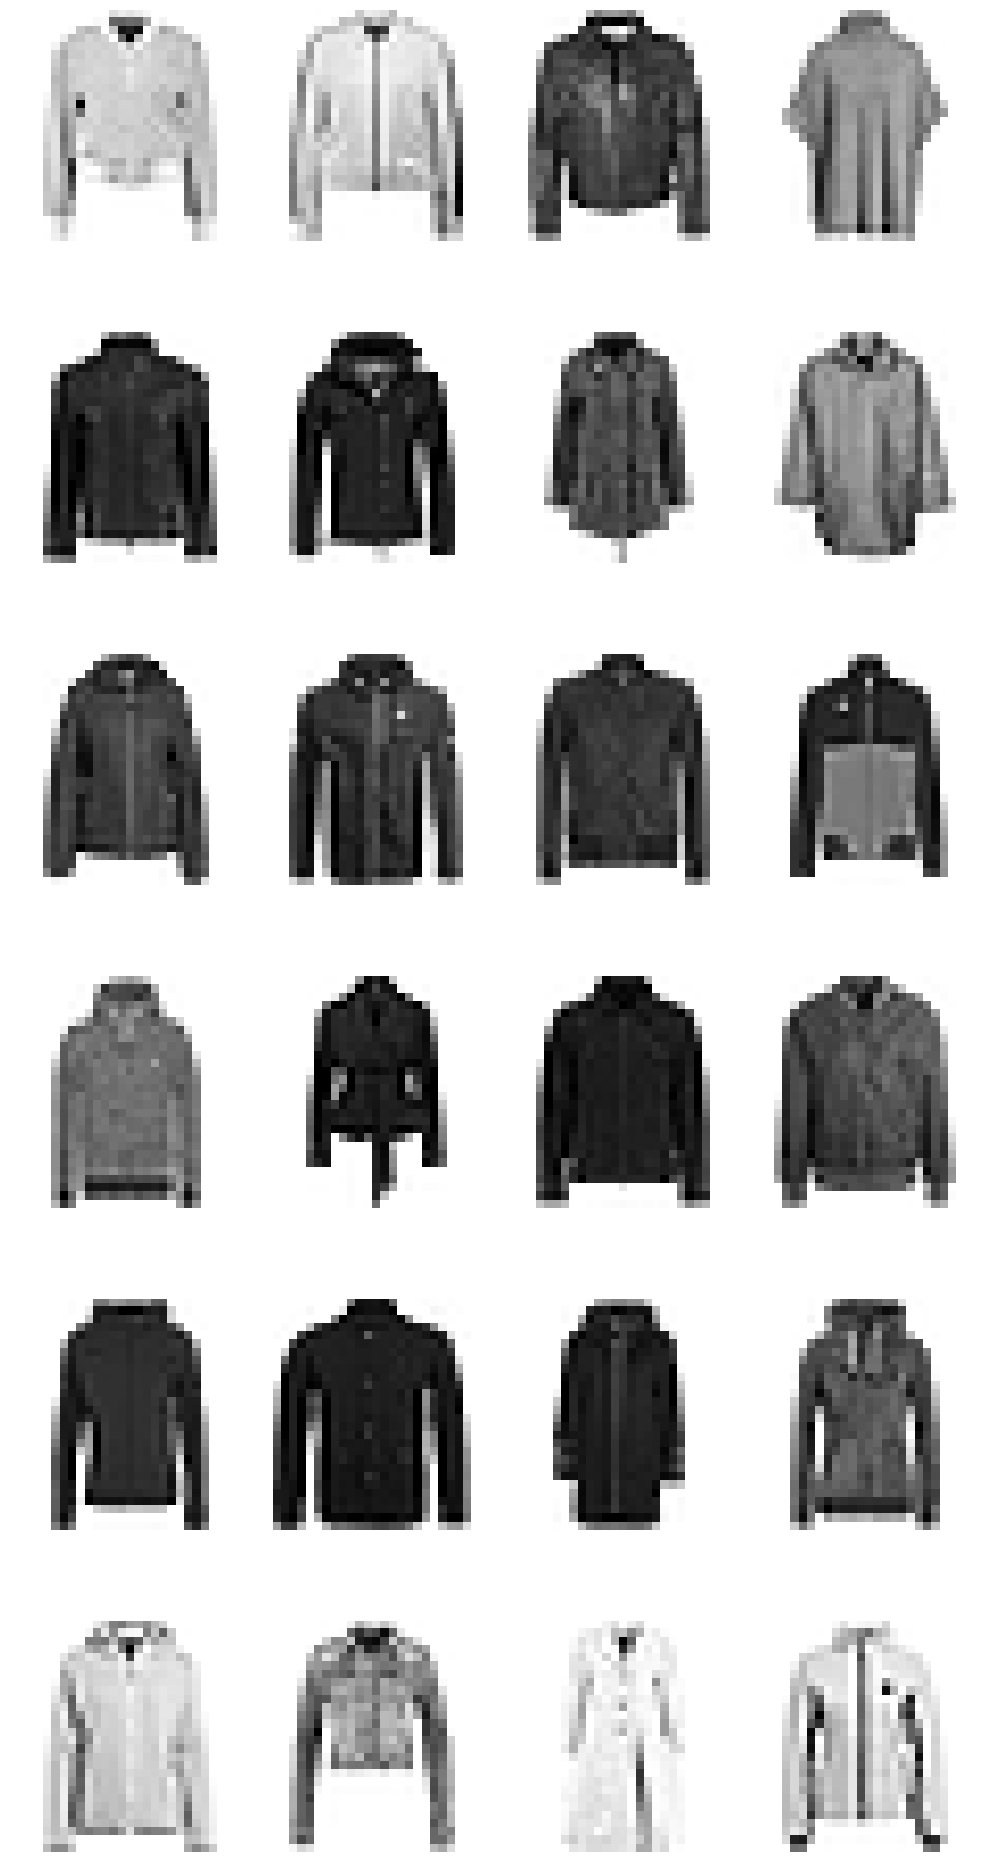

In [115]:
label_0_images = df[df["label"] == 0].drop("label", axis=1).sample(n=24, random_state=random_seed)
draw_grid(label_0_images.index.tolist())

Although some images are a bit ambiguous, most of them look to be coats. We'll assume that label=0 is a coat.

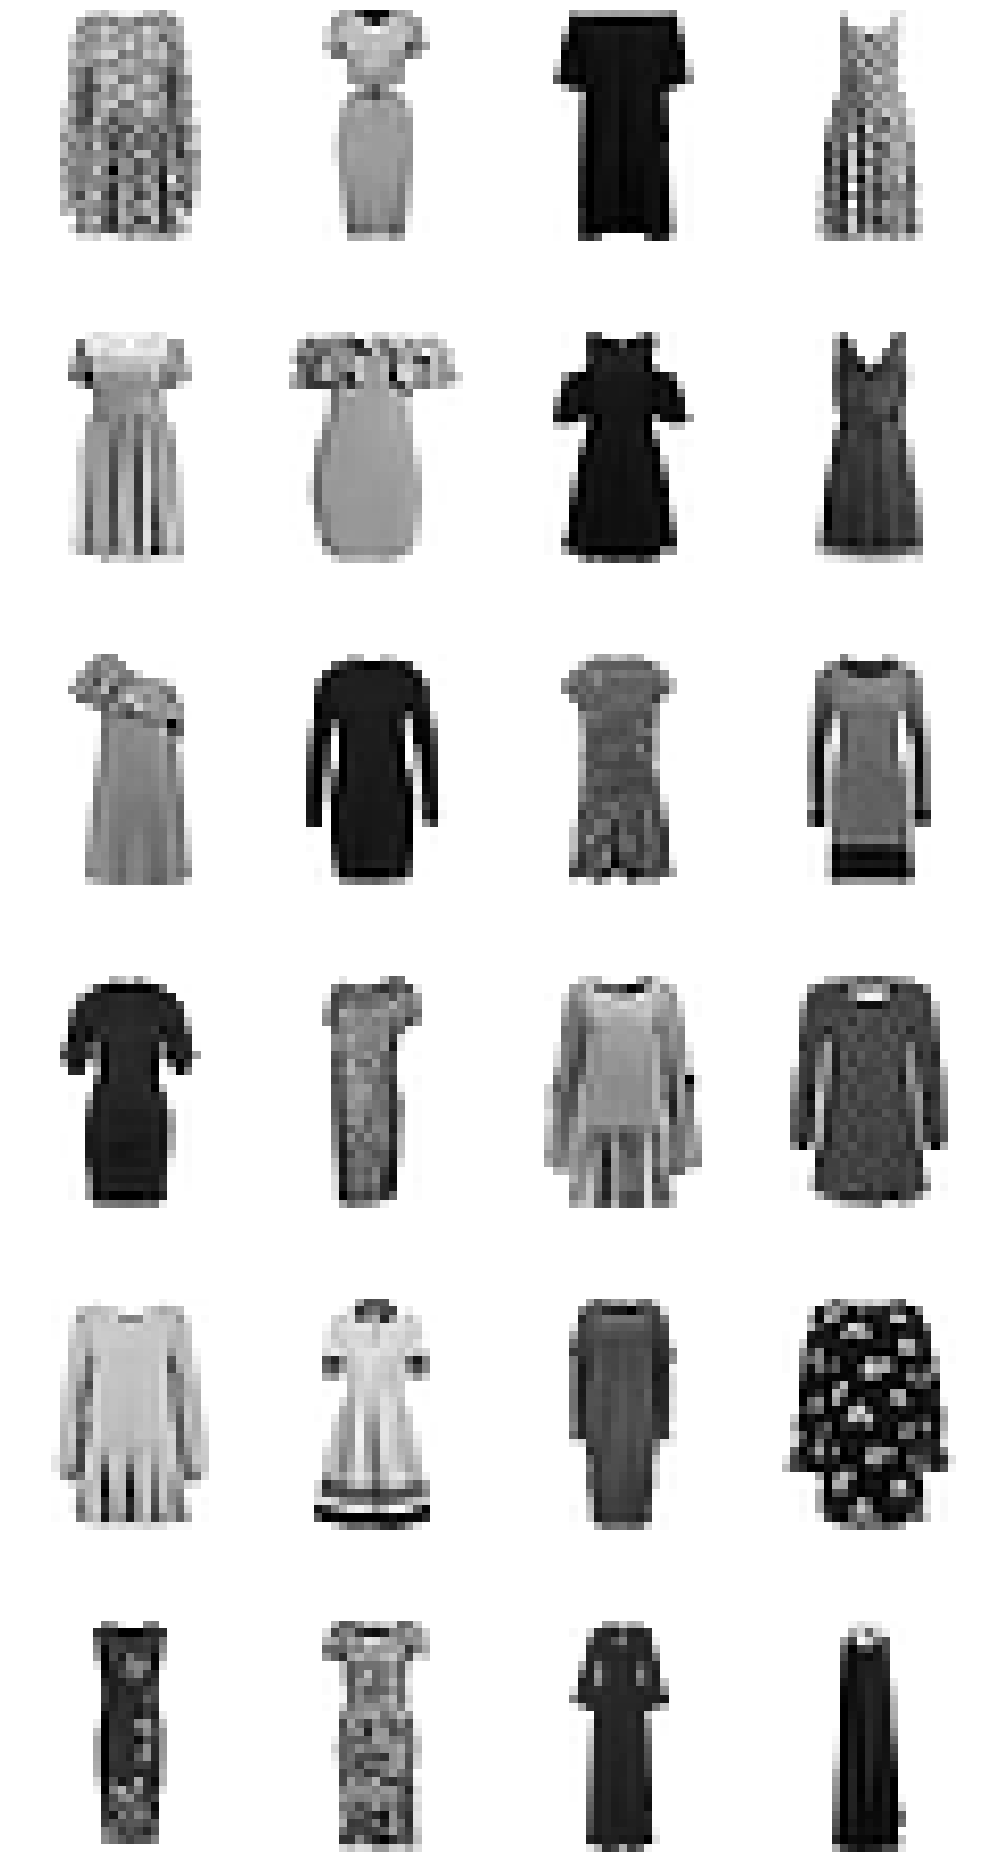

In [116]:
label_1_images = df[df["label"] == 1].drop("label", axis=1).sample(n=24, random_state=random_seed)
draw_grid(label_1_images.index.tolist())

Label 1 appears to be dresses, all of them look like dresses.

<h1>Applying the models</h1>
In this section, we'll apply SVM, Naive bayes and LDA models to train and correctly predict if an image is a coat or a dress.

Firstly, split the data into train, validate and test. We'll use train for training the model, validate to find optimal hyperparameters and model itself. We won't touch test data until we pick the final model. 

In [117]:
# Split the training dataset into 60% train and 40% rest
Xtrain, Xrest, Ytrain, yrest = train_test_split(
    df.drop(columns=['label']), df.label, test_size=0.4, random_state=random_seed
)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, Ytest, Yval = train_test_split(
    Xrest, yrest, test_size=0.6, random_state=random_seed
)

<h2>Support vector Machine (SVM)</h2>

We'll train using SVC library from scikit.

Support vector machine is great at handling large dimension classification data. We're trying to draw a line (hyperplane) to separate different classes of data. We're trying to maximize the distance between closest points from different classes. SVM is a very good model for this type of exercise due to high dimension of data. SVM was originally designed for image classification, where data is sparse. It's also great at finding non-linear relationships, which is common for images. 

We're optimizing for 2 hyperparameters:
- **C** - a parameter that punishes errors, the larger it is, the more errors get punished, the more correct each classification has to be. Large C risks overfitting, that's why we won't allow it to be greater.
- **kernel** - kernel function - an algorithm to compute the results of projection of data points into higher dimension
    - **linear** - can capture only linear relationships, uses dot product. It's fast when sparse data, which is true for us (many zeros). Does not use kernel trick
    - **poly** - uses polynomial function, capture more complex relationships
    - **rbf** - radial basis function - uses complex curves
    - **sigmoid** - uses hyperbolic tangent activation function 

We'll use accuracy score as a metric to train for hyperparameters, as it's a standard method to measure the prediction quality for categorical data.

In [118]:

def optimize_svc(param_grid: dict, Xtrain: pandas.DataFrame, Xval: pandas.DataFrame, **model_kwargs) -> (dict, float):
    
    param_comb = list(ParameterGrid(param_grid))

    val_acc = []
    for params in param_comb:
        def svc_eval(scalar: float):
            clf = SVC(C=scalar, **params, **model_kwargs)
            clf.fit(Xtrain, Ytrain)
            # to be able to minimize
            return -accuracy_score(Yval, clf.predict(Xval))
    
        opt_scalar = optimize.minimize_scalar(svc_eval, options={'maxiter': 100}, method='bounded', bounds=(0, 100))
        params["C"] = opt_scalar.x
                
        clf = SVC(**params, **model_kwargs)
        clf.fit(Xtrain, Ytrain)
        val_acc.append(accuracy_score(Yval, clf.predict(Xval)))
    
    best_params_svc = param_comb[np.argmax(val_acc)]
    
    return best_params_svc, max(val_acc)

param_grid_svc = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid']
}

best_params_svc, best_val_svc = optimize_svc(param_grid_svc, Xtrain, Xval, random_state=random_seed)
print("Best params:", best_params_svc, "accuracy score:", best_val_svc)


Best params: {'kernel': 'poly', 'C': np.float64(70.16262571098535)} accuracy score: 0.9444444444444444


We got an accuracy score of 94.44%, which is an awesome result. SVM is a great model for this problem, and it handles high dimensions really well even without reducing them. Also kernel=poly suggests that we have some important non-linear relationships.

Sometimes normalizing can help SVC model, because we already demonstrated that a picture can have different backgrounds. We don't want pictures of different scales to confuse the model, for example with darker background. We'll normalize the values to smooth the differences.  

In [119]:
scaler = StandardScaler()
Xtrain_normalized = scaler.fit_transform(Xtrain)
Xval_normalized = scaler.transform(Xval)

best_params_svc_normalized, best_val_svc_normalized = optimize_svc(param_grid_svc, Xtrain_normalized, Xval_normalized, random_state=random_seed)
print("Results for optimizing normalized SVC:")
print("Best params:", best_params_svc_normalized, "accuracy score:", best_val_svc_normalized)

Results for optimizing normalized SVC:
Best params: {'kernel': 'poly', 'C': np.float64(73.6068060546639)} accuracy score: 0.9555555555555556


Normalizing improved the accuracy score, and we got to 95.56%.

<h2>Naive Bayes classificator</h2>

Next, we'll use naive bayes to classify the pictures. It classifies data based on probabilities, based on Bayes theorem, that handles conditional probabilities.

P(y | x) - probability of class label (predicted value) given our pixels (features).

It's called "naive", because we're assuming, that features are independent. This isn't always true in the real world, but it's good for our calculations. It calculates how likely each pixel falls under which class, and multiplies them for each image to give the final probability.

We'll use GaussianNB scipy implementation, we're using normal distribution to model our probabilities. It's a great model for our image problem, as it's fast, works with high dimensions (just multiplies probabilities) and handles sparse data well. We also get probabilities that each picture belongs to a given class.

In [120]:

def get_best_accuracy(model: Type[GaussianNB | LinearDiscriminantAnalysis], param_grid: dict, Xtrain: pd.DataFrame, Xval:pd.DataFrame, 
                      **model_kwargs) -> (dict, float):
    param_comb = ParameterGrid(param_grid)

    val_acc = []
    for params in param_comb:
        dt = model(**params, **model_kwargs)
        dt.fit(Xtrain, Ytrain)
        val_acc.append(accuracy_score(Yval, dt.predict(Xval)))
        
    best_params = param_comb[np.argmax(val_acc)]
    print("Best params:", best_params, "accuracy score:", max(val_acc))

    return best_params, max(val_acc)

In [121]:
param_grid_gaussian = {
    "priors": [None]
}

print("Optimizing Gaussian NB results:")
best_params_gaussian, best_val_gaussian = get_best_accuracy(GaussianNB, param_grid_gaussian, Xtrain, Xval)


Optimizing Gaussian NB results:
Best params: {'priors': None} accuracy score: 0.8722222222222222


We got 87.22%, it's also a great result, considering that we didn't even use any hyperparameters for optimization. We don't need normalization as Naive Bayes calculates each feature independently.

We're going to demonstrate the GaussianNB algorithm with showing probability of a random picture from label=0 and label=1

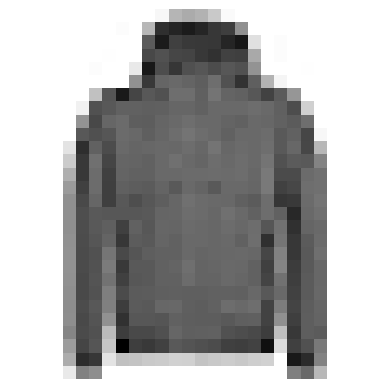

Bayes probability label=0:
  P(class = 0) = 1.0000
  P(class = 1) = 0.0000


In [122]:
gaussian_trained_model = GaussianNB(**best_params_gaussian)
gaussian_trained_model.fit(Xtrain, Ytrain)

index_label0 = np.where(Yval == 0)[0][0]
label_0_image = Xval.iloc[[index_label0]]

def draw_picture_xval(picture_index: int):
     picture = Xval.iloc[picture_index].values.reshape(28, 28)
     plt.imshow(picture, cmap='gray_r', interpolation='nearest', vmin=0, vmax=255)
     plt.axis('off')
     plt.show()

probabilities_0 = gaussian_trained_model.predict_proba(label_0_image)[0]

draw_picture_xval(index_label0)
print("Bayes probability label=0:", )
for cls, p in zip(gaussian_trained_model.classes_, probabilities_0):
    print(f"  P(class = {cls}) = {p:.4f}")


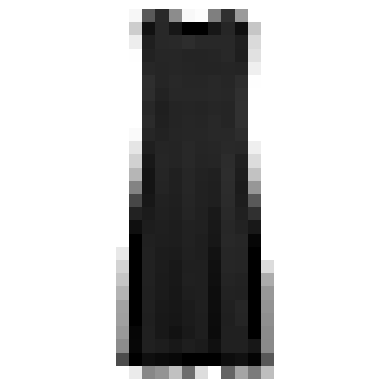

Bayes probability label=0:
  P(class = 0) = 0.0000
  P(class = 1) = 1.0000


In [123]:
index_label1 = np.where(Yval == 1)[0][0]
label_1_image = Xval.iloc[[index_label1]]

probabilities_1 = gaussian_trained_model.predict_proba(label_1_image)[0]

draw_picture_xval(index_label1)
print("Bayes probability label=0:", )
for cls, p in zip(gaussian_trained_model.classes_, probabilities_1):
    print(f"  P(class = {cls}) = {p:.4f}")


Looks like our Bayes model is 100% certain on both of our images.

<h2>Linear discriminant analysis</h2>

Similarly to SVM, LDA also tries to project the optimal line/hyperplane to correctly separate classes, for us coats vs dresses. While SVM tries to project the line to maximize the distance between the closest points of each class (support vector), LDA tries to project the line to maximize the class separability, by maximizing the distance between different class variance (centers) and within class variance. It pulls different classes apart while keeping the same classes together.

max(between class var / within class var)

LDA works well with images and high dimensions, just like SVM. A disadvantage of this model is, that it assumes, that classes can be separated by a linear combination of features. This may be an issue, since our data don't necessarily have linear relationships, as we showed earlier. This model may improve with dimension reduction. LDA further assumes that features follow normal distribution, each class has its own mean all classes have the same covariance matrix.

Hyperparameters:
   - **solver** - which algorithm LDA uses to find the direction of the projected hyperplane to separate classes
        - **svd** - singular Value Decomposition
        - **lsqr** - least-squares solution
   - **shrinkage** - technique for regularizing the covariance matrix between each class. Reduces overfitting and smoothes out the matrix. Useful mainly for high dimensional data.

In [124]:
param_grid_lda = {
    "solver": ['svd', 'lsqr'],
    "shrinkage": [None]
}

print("LDA optimizing results:")
best_lda_params, best_val_lda = get_best_accuracy(LinearDiscriminantAnalysis, param_grid_lda, Xtrain, Xval)

# we have to split this into 2, as svd doesn't support shrinkage: auto
param_grid_lda = {
    "solver": ['lsqr'],
    "shrinkage": ["auto"]
}

best_lda_params_2, best_val_lda_2 = get_best_accuracy(LinearDiscriminantAnalysis, param_grid_lda, Xtrain, Xval)
if best_val_lda_2 > best_val_lda:
    best_lda_params, best_val_lda = best_lda_params_2, best_val_lda_2


LDA optimizing results:
Best params: {'solver': 'svd', 'shrinkage': None} accuracy score: 0.7916666666666666
Best params: {'solver': 'lsqr', 'shrinkage': 'auto'} accuracy score: 0.9416666666666667


Shrinkage=auto helped out a lot. It's not that surprising, as we have very little data compared to our dimension. Shrinkage fixed the noise in our data.

Let's also try to normalize the data as well, for similar reasons as SVM.

In [125]:
param_grid_lda = {
    "solver": ['svd', 'lsqr'],
    "shrinkage": [None]
}

print("LDA with normalization optimizing results:")
best_lda_params_normalized, best_val_lda_normalized = get_best_accuracy(LinearDiscriminantAnalysis, param_grid_lda, Xtrain_normalized, Xval_normalized)

# we have to split this into 2, as svd doesn't support shrinkage: auto
param_grid_lda = {
    "solver": ['lsqr'],
    "shrinkage": ["auto"]
}

best_lda_params_2_normalized, best_val_lda_2_normalized = get_best_accuracy(LinearDiscriminantAnalysis, param_grid_lda, Xtrain_normalized, Xval_normalized)
if best_val_lda_2_normalized > best_val_lda_normalized:
    best_lda_params_normalized, best_val_lda_normalized = best_lda_params_2_normalized, best_val_lda_2_normalized

LDA with normalization optimizing results:
Best params: {'solver': 'lsqr', 'shrinkage': None} accuracy score: 0.7972222222222223
Best params: {'solver': 'lsqr', 'shrinkage': 'auto'} accuracy score: 0.9416666666666667


Normalizing helped slightly when shrinkage=None and didn't help when shrinkage=auto. We won't be using normalization for LDA.

<h2>Drawing random picture using LDA</h2>

Next, we'll draw 5 random pictures for each class generated with our LDA model to see how our model expects the average picture to look like.

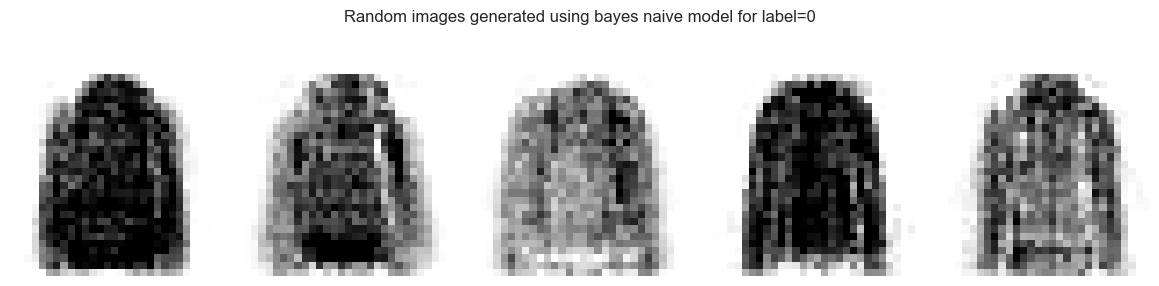

In [126]:

def draw_random_images(model: LinearDiscriminantAnalysis, label: int):
    mean = model.means_[label]
    cov = model.covariance_
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axes):
        # ensure reproducibility
        np.random.seed(random_seed+i)
        generated_image = np.random.multivariate_normal(mean=mean, cov=cov).reshape(28, 28)
        ax.imshow(generated_image, cmap='gray_r', interpolation='nearest', vmin=0, vmax=255)
        ax.axis('off')
        
    plt.suptitle(f"Random images generated using bayes naive model for label={label}")
    plt.tight_layout(pad=2.0)
    plt.show()
    

lda_model = LinearDiscriminantAnalysis(**best_lda_params)
lda_model.fit(Xtrain, Ytrain)
draw_random_images(lda_model, 0)

Our model views the coats quite well I'd say. It clearly sees the sleeves, you can also see that it's not shirts.

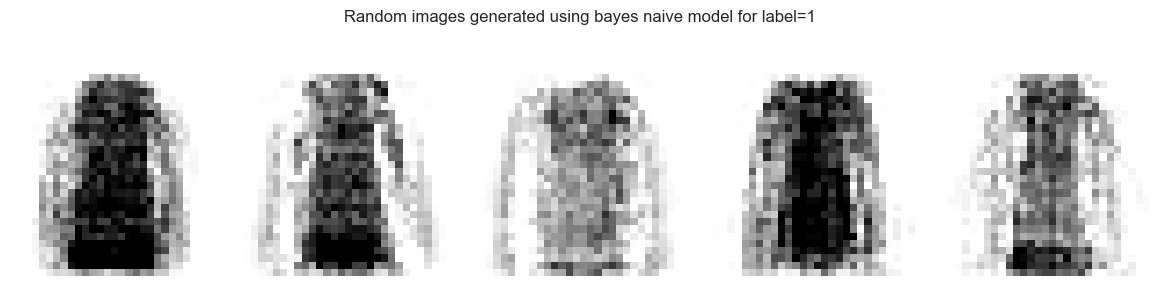

In [127]:
draw_random_images(lda_model, 1)

Seems like the LDA model is focusing on the skirt part when predicting dress. It may make sense, as it's the main difference between dresses and coats. Even though this doesn't look like a dress, it's useful when separating coats and dresses.

<h1>Reduction of dimensionality</h1>

We're going to try PCA and LLE to reduce the dimensionality. 784 dimensions is a lot for our models to handle, it may be useful to compress it into fewer. We'll use both PCA and LLE on all 3 of our models, and see if our accuracy score improves.

<h2>Principal Component Analysis</h2>
We're going to use principal component analysis to compress the dimensions into fewer. 

PCA is an unsupervised dimension reduction technique. PCA finds directions along which the data spread out the most and projects those data. The first dimension will capture the most variance in the data, second the second most and so on. It generates as many axes, as you set. New axe won't be correlated, because it's an orthogonal projection.

PCA is great for reducing the noise in the data - uncorrelated patterns and duplicates, it also avoids overfitting.

Hyperparameters:
- **n_components** - how many dimensions should the new data have.

<h3>Optimizing SVM with PCA</h3>

In [128]:
param_grid_pca = {
    "n_components": [i for i in range(2, 100)],
}

param_grid_svc = {
    "kernel": ['poly', 'rbf', 'sigmoid']
}
    
pca_param_comb = list(ParameterGrid(param_grid_pca))

best_params_pca_svc = {}
best_pca_svc_val = 0
accuracies_pca_svc = []
    
for dim_param in pca_param_comb:
    dim_model = PCA(**dim_param, random_state=random_seed)
    Xtrain_pca = dim_model.fit_transform(Xtrain)
    Xval_pca = dim_model.transform(Xval)
    best_params_pca_svc_temp, best_pca_svc_val_temp = optimize_svc(param_grid_svc, Xtrain_pca, Xval_pca, random_state=random_seed)
    best_params_pca_svc_temp.update(dim_param)
    accuracies_pca_svc.append(best_pca_svc_val_temp)
    
    if best_pca_svc_val_temp > best_pca_svc_val:
        best_params_pca_svc, best_pca_svc_val = best_params_pca_svc_temp, best_pca_svc_val_temp
    
print("Optimizing of SVC with PCA results:")
print("best params:", best_params_pca_svc, "accuracy score:", best_pca_svc_val)


Optimizing of SVC with PCA results:
best params: {'kernel': 'rbf', 'C': np.float64(9.258004768811944), 'n_components': 25} accuracy score: 0.9666666666666667


PCA helped the SVC model to gain even greater performance. Reducing the dimensions to 25 gave the best result, 96.67%! That means that we can project our 784 pixel features into 25 and still keep our patterns and relationships. It ended up behaving even better than regularized SVC. Our best kernel is now rbf, radial basis function. (normalizing before PCA gave slightly worse accuracy, that's why I skipped it).

I had to remove kernel=linear, as that took hours to compute. I expected our models to run faster with fewer dimensions, but kernel=linear is different. It's true that it can be faster with fewer features, but it also gets slower if our data get dense, which is exactly what PCA is doing. What a surprising turn of events.

We'll also graph the accuracy as we increase dimensions.

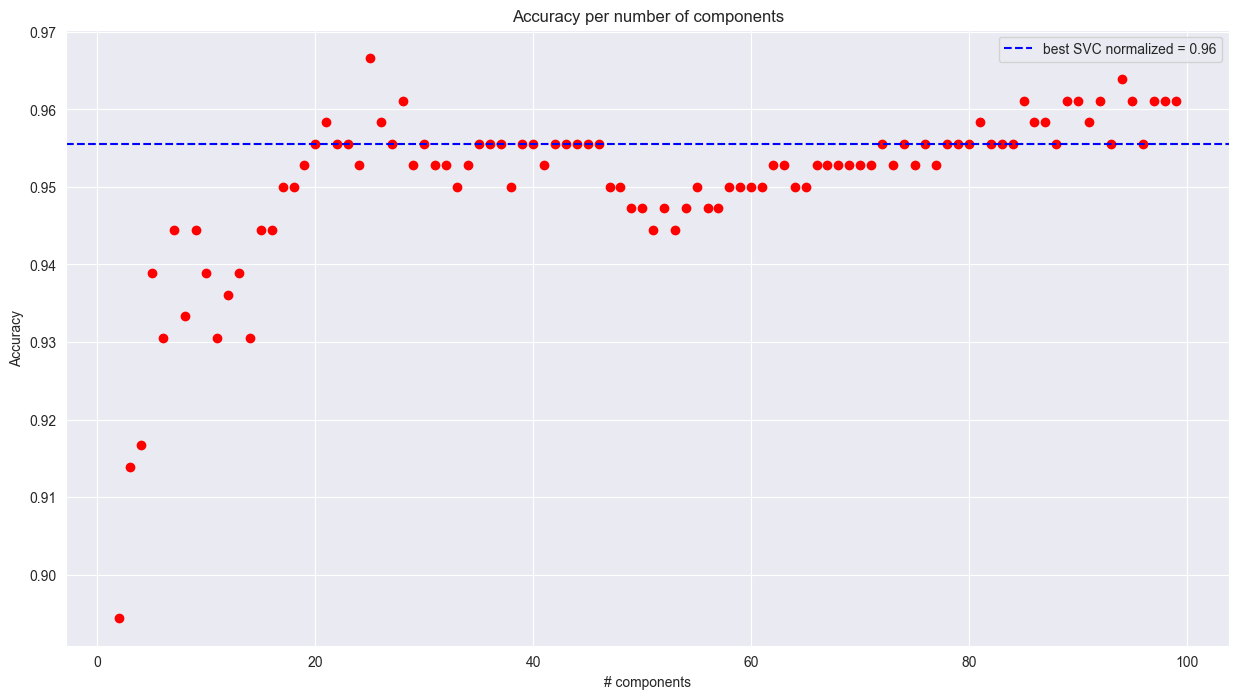

In [129]:
def draw_pca_dimension_accuracies(accuracies: list, y_value: float, label: str):
    plt.subplots(1, 1, figsize=(15, 8))
    plt.scatter(range(2, 100), accuracies, c='red')
    plt.title(u"Accuracy per number of components")
    plt.xlabel('# components')
    plt.ylabel('Accuracy')
    
    plt.axhline(y=y_value, color='blue', linestyle='--', label=f'best {label} = {round(y_value, 2)}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
draw_pca_dimension_accuracies(accuracies_pca_svc, best_val_svc_normalized, "SVC normalized")

Accuracy of SVC is quite good when the number of dimension is greater than 5. We see a peak of accuracy around 25 dimensions, and then again around 100 dimensions. We know that the best accuracy is with kernel=rbf at n=25, so this peak may be rbf, and the other one might be a kernel=poly. However the differences aren't that big, and most dimensions are around the best optimized normalized SVC accuracy.

<h3>Optimizing Naive Bayes with PCA</h3>

In [130]:

def optimize_with_dimension_reduction_simple(Xtrain: pd.DataFrame, Xval: pd.DataFrame, param_grid_model: dict, param_grid_dim: dict, 
                                             model: Type[GaussianNB | LinearDiscriminantAnalysis],
                                             reduce_dim_model: Type[PCA | LocallyLinearEmbedding]) -> (dict, float, list):
    """ Function for optimizing models with reducing of the dimension """

    param_comb_model = ParameterGrid(param_grid_model)
    param_comb_dim = ParameterGrid(param_grid_dim)
    
    accuracies_to_plot = []
    best_val = 0
    best_params = {}
    for dim_param in param_comb_dim:
        val_acc = []
        dim_model = reduce_dim_model(**dim_param, random_state=random_seed)
        Xtrain_pca = dim_model.fit_transform(Xtrain)
        Xval_pca = dim_model.transform(Xval)
        
        for params_model in param_comb_model:
            clf = model(**params_model)
            clf.fit(Xtrain_pca, Ytrain)
            val_acc.append(accuracy_score(Yval, clf.predict(Xval_pca)))
            params_model.update(dim_param)
        
        accuracies_to_plot.append(max(val_acc))
        if max(val_acc) > best_val:
            best_params = param_comb_model[np.argmax(val_acc)]
            best_params.update(dim_param)
            best_val = max(val_acc)
            
    print("Best params:", best_params, "accuracy score:", best_val)
    return best_params, best_val, accuracies_to_plot


In [131]:

print("GaussianNB with PCA optimizing results:")
best_gaussian_pca_params, best_gaussian_pca_val, gaussian_accuracies = optimize_with_dimension_reduction_simple(Xtrain_normalized, Xval_normalized,
                                                                                                                param_grid_gaussian, param_grid_pca, 
                                                                                                                GaussianNB, PCA)


GaussianNB with PCA optimizing results:
Best params: {'priors': None, 'n_components': 8} accuracy score: 0.9305555555555556


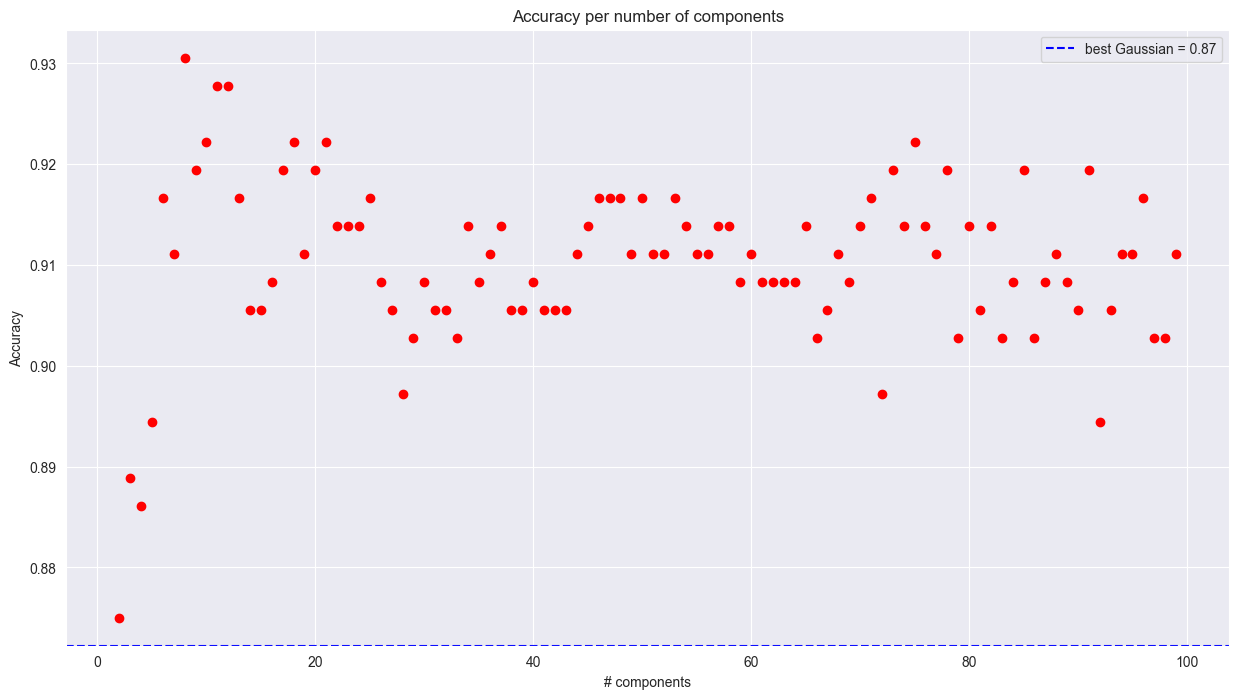

In [132]:
draw_pca_dimension_accuracies(gaussian_accuracies, best_val_gaussian, "Gaussian")

Reducing dimensions with PCA had a huge impact on the accuracy of the Naive Bayes. Reducing dimensions helped in all cases, with the best being 8. Naive Bayes assumes that all features are independent, which probably isn't the case on the original data set. What PCA does is making the data uncorrelated, which greatly helped the model, this isn't that shocking. Normalizing before applying PCA gave better results than not normalizing, that's why I kept the normalized version.

<h3>Optimizing Linear discriminant analysis with PCA</h3>

In [133]:
param_grid = {
    "solver": ['lsqr', 'eigen'],
    "shrinkage": [None, 'auto'],
}

print("LDA with PCA optimizing results:")
best_lda_pca_params, best_lda_pca_val, lda_accuracies = optimize_with_dimension_reduction_simple(Xtrain_normalized, Xval_normalized,
                                                                                                 param_grid, param_grid_pca, 
                                                                                                 LinearDiscriminantAnalysis, PCA)

param_grid = {
    "solver": ['svd'],
    "shrinkage": [None],
}

best_lda_pca_params_temp, best_lda_pca_val_temp, lda_accuracies_temp = optimize_with_dimension_reduction_simple(Xtrain_normalized, Xval_normalized,
                                                                                                                param_grid, param_grid_pca, 
                                                                                                                LinearDiscriminantAnalysis, PCA)

if best_lda_pca_val_temp > best_lda_pca_val:
    best_lda_pca_params, best_lda_pca_val, lda_accuracies = best_lda_pca_params_temp, best_lda_pca_val_temp, lda_accuracies_temp

LDA with PCA optimizing results:
Best params: {'solver': 'lsqr', 'shrinkage': None, 'n_components': 61} accuracy score: 0.9555555555555556
Best params: {'solver': 'svd', 'shrinkage': None, 'n_components': 61} accuracy score: 0.9555555555555556


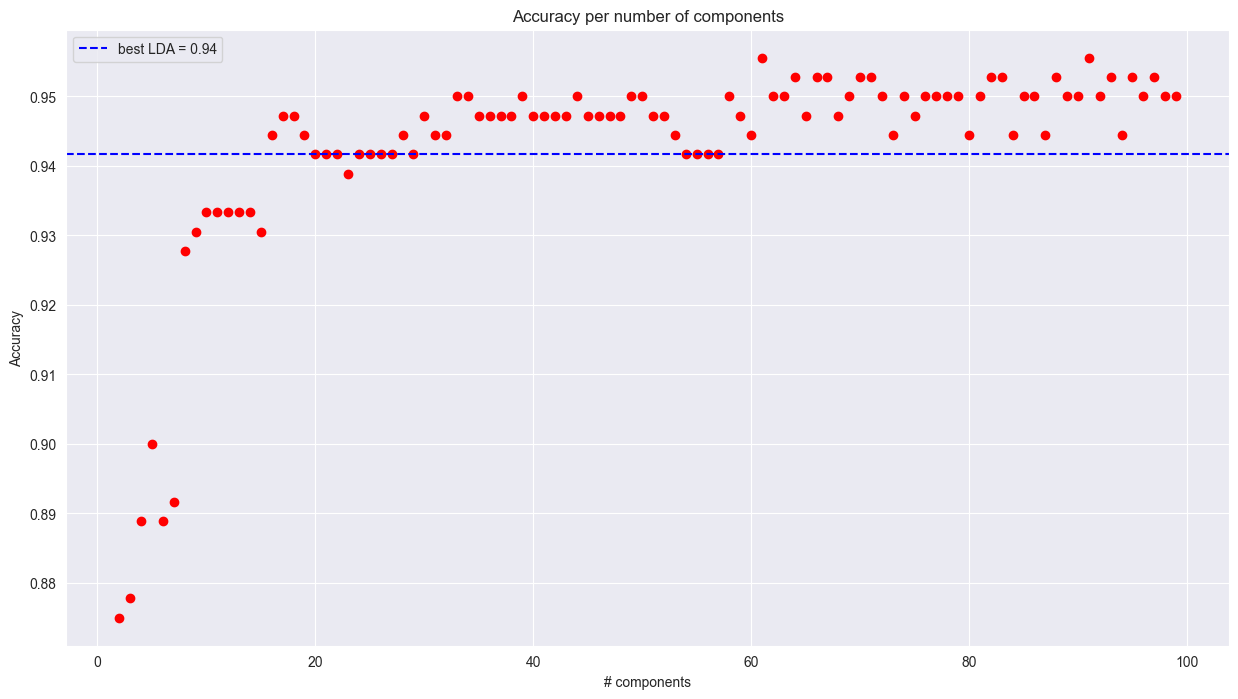

In [134]:
draw_pca_dimension_accuracies(lda_accuracies, best_val_lda, "LDA")

PCA with components of over 15 gave better results than not using PCA. Best dimension ended up being 61, with the best values being around 60-99, but it's only a marginal improvement over not using PCA.

<h2>Conclusions with using PCA</h2>
PCA was a significant improvement only for Naive Bayes, probably because it made the features uncorrelated. PCA was only a slight improvement for PCM and LDA.

<h2>Locally Linear Embedding</h2>

Compared to PCA, that tries to keep the global distances between different classes, LLE tries to preserve how much neighbor points relate to each other. Every point (image) is approximated as a linear combination of its nearest N neighbors. It also tries to find a lower dimension representation of the same relationships.

It may capture local relationships that PCA can't see, like same sleeves or collars on a coat, while PCA will try to make a global pattern. It can also preserve complicated, non-linear relationships. It's definitely a good attempt at trying something different from PCA for this problem.

<h3>LLE for SVM</h3>


In [135]:

param_grid_lle = {
    "n_neighbors": [i for i in range(5, 40, 3)],
    "n_components": [i for i in range(5, 51, 5)],
}

lle_param_comb = ParameterGrid(param_grid_lle)

best_params_lle_svc = {}
best_lle_svc_val = 0
accuracies_lle_svc_neighbors = defaultdict(lambda: float('-inf'))
accuracies_lle_svc_components = defaultdict(lambda: float('-inf'))
    
for dim_param in lle_param_comb:
    dim_model = LocallyLinearEmbedding(**dim_param, random_state=random_seed)
    Xtrain_lle = dim_model.fit_transform(Xtrain)
    Xval_lle = dim_model.transform(Xval)
    best_params_lle_svc_temp, best_lle_svc_val_temp = optimize_svc(param_grid_svc, Xtrain_lle, Xval_lle, random_state=random_seed)
    best_params_lle_svc_temp.update(dim_param)
    if best_lle_svc_val_temp > accuracies_lle_svc_neighbors[dim_param["n_neighbors"]]:
        accuracies_lle_svc_neighbors[dim_param["n_neighbors"]] = best_lle_svc_val_temp
    if best_lle_svc_val_temp > accuracies_lle_svc_components[dim_param["n_components"]]:
        accuracies_lle_svc_components[dim_param["n_components"]] = best_lle_svc_val_temp
        
    if best_lle_svc_val_temp > best_lle_svc_val:
        best_params_lle_svc, best_lle_svc_val = best_params_lle_svc_temp, best_lle_svc_val_temp
    
print("Optimizing of SVC with LLE results:")
print("best params:", best_params_lle_svc, "accuracy score:", best_lle_svc_val)


Optimizing of SVC with LLE results:
best params: {'kernel': 'rbf', 'C': np.float64(7.29491491477365), 'n_components': 20, 'n_neighbors': 29} accuracy score: 0.9611111111111111


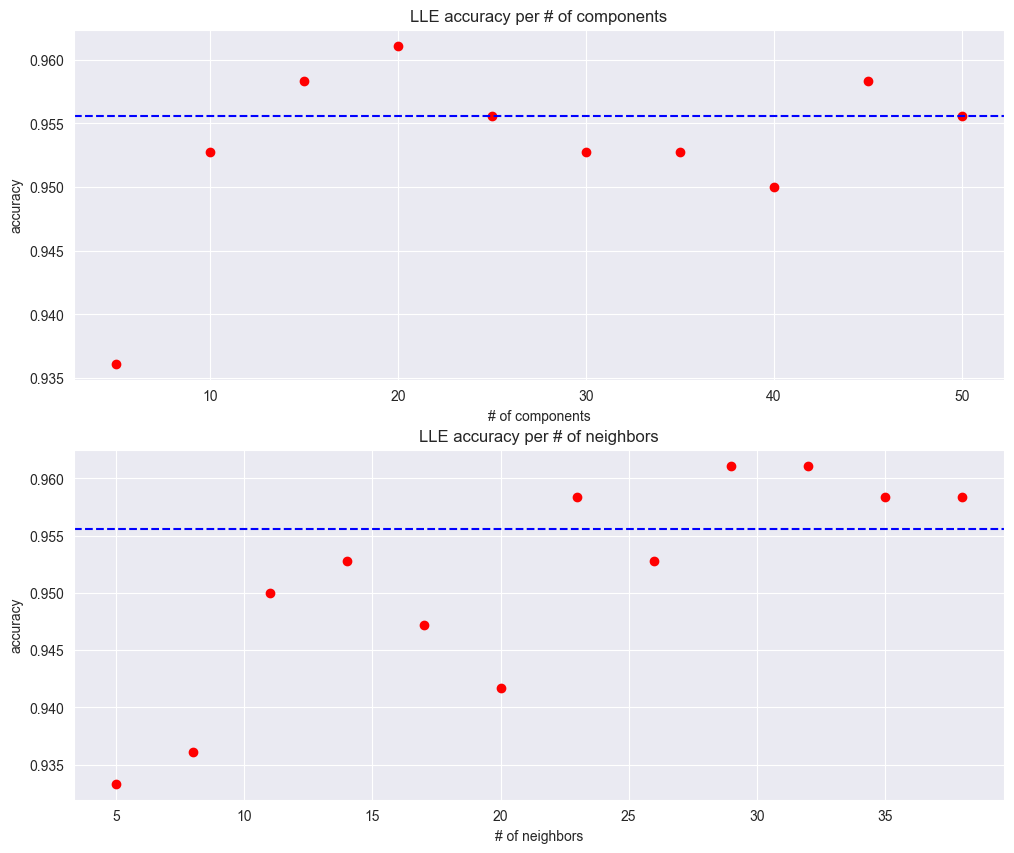

In [136]:
def draw_lle_accuracies(accuracies_components: dict, accuracies_neighbors: dict, y_value: float, label: str):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    key_ = sorted(accuracies_components.keys())
    axes[0].scatter(key_, [accuracies_components[k] for k in accuracies_components], color='red')
    axes[0].set_title("LLE accuracy per # of components")
    axes[0].set_xlabel("# of components")
    axes[0].set_ylabel("accuracy")
    axes[0].grid(True)
    axes[0].axhline(y=y_value, color='blue', linestyle='--', label=f'best {label} = {round(y_value, 2)}')
    
    key_ = sorted(accuracies_neighbors.keys())
    axes[1].scatter(key_, [accuracies_neighbors[k] for k in accuracies_neighbors], color='red')
    axes[1].set_title("LLE accuracy per # of neighbors")
    axes[1].set_xlabel("# of neighbors")
    axes[1].set_ylabel("accuracy")
    axes[1].grid(True)
    axes[1].axhline(y=y_value, color='blue', linestyle='--', label=f'best {label} = {round(y_value, 2)}')
    plt.grid(True)
    plt.show()
    
    
draw_lle_accuracies(accuracies_lle_svc_components, accuracies_lle_svc_neighbors, best_val_svc_normalized, "SVC optimized with LLE")
    

Using LLE with SVC ended up being slightly better than using SVC with normalization, but the performance is not better than PCA. The differences are very small though. The best number of features ended up being around 20, and # of neighbors was the best with higher number, the best was around 30. Normalization before LLE ended up giving a slightly worse result, so it was not included. 

In [137]:
print("GaussianNB with LLE optimizing results:")
best_gaussian_lle_params, best_gaussian_lle_val, _ = optimize_with_dimension_reduction_simple(Xtrain, Xval, param_grid_gaussian, 
                                                                                              param_grid_lle, GaussianNB, LocallyLinearEmbedding)

GaussianNB with LLE optimizing results:
Best params: {'priors': None, 'n_components': 40, 'n_neighbors': 14} accuracy score: 0.925


LLE ended up helping Naive Bayes as well, but the performance was slightly worse than using PCA. Normalization didn't help here.

In [138]:
param_grid = {
    "solver": ['lsqr', 'eigen'],
    "shrinkage": [None, 'auto'],
}

print("LDA with lle optimizing results:")
best_lda_lle_params, best_lda_lle_val, lda_accuracies = optimize_with_dimension_reduction_simple(Xtrain, Xval,
                                                                                                 param_grid, param_grid_lle, 
                                                                                                 LinearDiscriminantAnalysis, LocallyLinearEmbedding)

param_grid = {
    "solver": ['svd'],
    "shrinkage": [None],
}

best_lda_lle_params_temp, best_lda_lle_val_temp, lda_accuracies_temp = optimize_with_dimension_reduction_simple(Xtrain, Xval,
                                                                                                                param_grid, param_grid_lle, 
                                                                                                                LinearDiscriminantAnalysis,
                                                                                                                LocallyLinearEmbedding)

if best_lda_lle_val_temp > best_lda_lle_val:
    best_lda_lle_params, best_lda_lle_val, lda_accuracies = best_lda_lle_params_temp, best_lda_lle_val_temp, lda_accuracies_temp

LDA with lle optimizing results:
Best params: {'solver': 'lsqr', 'shrinkage': None, 'n_components': 20, 'n_neighbors': 35} accuracy score: 0.9555555555555556
Best params: {'solver': 'svd', 'shrinkage': None, 'n_components': 20, 'n_neighbors': 35} accuracy score: 0.9555555555555556


Using LLE ended up having the same result as using PCA for LDA. Both helped to improve the model slightly. Normalization before LLE didn't help.

<h1>Training the models, conclusions</h1>

All models ended up being very good for the image classification task. All of them are known to work well with multidimensional data, and they were also good at uncovering non-linear relationships/patterns between pixels of images.

SVM and LDA ended up performing very well, with accuracies of over 95%. Naive Bayes was slightly lagging behind, but one of the reasons may be having no hyperparameters to optimize.

Using dimension reduction, both PCA and LLE ended up helping all the models. For SVM and LDA it ended up being only a slight improvement, while for Naive Bayes, it was a significant improvement. None of these results are shocking, as PCA and LLE are good at handling high dimensions on their own, while Naive Bayes was helped with reducing correlations between features.

The winner model ended up being SVM with PCA, with impressive 96.67% accuracy.


<h1>Calculating accuracy on new data and evaluating</h1>

We'll calculate, how accurate our best model is on a new data, and evaluate our evaluate.csv data.

In [139]:
dim_model = PCA(n_components=best_params_pca_svc["n_components"], random_state=random_seed)
Xtrain_pca = dim_model.fit_transform(Xtrain)
Xtest_pca = dim_model.transform(Xtest)

best_model = SVC(**{k: v for k, v in best_params_pca_svc.items() if k != "n_components"})
best_model.fit(Xtrain_pca, Ytrain)
Ytest_predicted = best_model.predict(Xtest_pca)

acc = accuracy_score(Ytest, Ytest_predicted)
f1 = f1_score(Ytest, Ytest_predicted)
auc = roc_auc_score(Ytest, Ytest_predicted)

print("Prediction scores on a new data:")
print(f"Accuracy score: {round(acc, 4) * 100}%")
print(f"f1 score: {round(f1, 4) * 100}%")
print(f"auc score: {round(auc, 4) * 100}%")


Prediction scores on a new data:
Accuracy score: 93.75%
f1 score: 93.88%
auc score: 93.74%


Our accuracy, F1 and AUC scores ended up being very similar. The model is good at predicting our label on the average case, and it's good at predicting positive cases while not mislabeling negatives as positives.

Our data is balanced, therefore Accuracy score is the best metric to use. We're predicting the correct label 93.75% of the time.

<h2>Evaluating evaluate.csv data</h2>
We're going to predict the unknown labels.

In [140]:
df_result = pd.read_csv('evaluate.csv')
df_result = df_result.set_index("ID", drop=True)

df_transformed = dim_model.transform(df_result)
labels_predicted = best_model.predict(df_transformed)

df_output = pd.DataFrame({
    'ID': df_result.index,
    'label': labels_predicted
})

df_output.to_csv('results.csv', index=False)
